# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from tradnet_regression import *

## Set Inputs

In [2]:
seed = 7
n_samples = 10000
num_metaims = 5             # NOTE: Here this variable denotes the number of Intensity Measures to use

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_pga_dataset = '../../RC_Frame_large/pga_all_new.parquet'

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'tip_displacement', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
# Eliminate Outliers
predictors_all = predictors_all[predictors_all['drift_ratio_pct_max']<20].reset_index(drop = True)


In [6]:
pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
predictors_all = predictors_all.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
                                      left_on = 'gm_index', right_index = True)

We assume the collapse capacity of the building to be 12 inches

In [7]:
# capacity = 12
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Prepare training data

In [8]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['drift_ratio_pct_max']

# cols_gm = ['pga', 'pgv', 'arias', 'cav', 'ASI_05']

# cols_gm = ['pga', 'pgv', 'cav', 'sa01', 'sa02', 'ASI_05', 'ASI_10', 'arias']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa02', 'sa03', 'sa06', 'sa10']
cols_gm = ['pga', 'pgv', 'sa01', 'sa03', 'sa10']
# cols_gm = ['pga', 'pgv', 'sa01', 'sa03']
# cols_gm = ['pga', 'pgv', 'sa01']
# cols_gm = ['pga', 'pgv']
# cols_gm = ['pga']

x_data, x_val, x_test, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                            val_data, 
                                                                            test_data, 
                                                                            cols2scale, 
                                                                            cols_gm)


## Train TradNet Model

In [9]:
max_epochs = 15000
interval = 500

start = timeit.default_timer()
model, error_evolution_training, error_evolution_val = train_tradnet_model(x_data, 
                                                                      x_val, 
                                                                      y_data, 
                                                                      y_val, 
                                                                      train_data, 
                                                                      val_data,
                                                                      max_epochs = max_epochs,
                                                                      interval = interval)
stop = timeit.default_timer()

Epoch 1: Training RMSE Loss 4.4225, Validation RMSE Loss 4.4610
Epoch 500: Training RMSE Loss 2.6095, Validation RMSE Loss 2.6014
Epoch 1000: Training RMSE Loss 2.0570, Validation RMSE Loss 2.0448
Epoch 1500: Training RMSE Loss 1.8967, Validation RMSE Loss 1.8961
Epoch 2000: Training RMSE Loss 1.8125, Validation RMSE Loss 1.8395
Epoch 2500: Training RMSE Loss 1.7427, Validation RMSE Loss 1.7875
Epoch 3000: Training RMSE Loss 1.6700, Validation RMSE Loss 1.7232
Epoch 3500: Training RMSE Loss 1.5975, Validation RMSE Loss 1.7005
Epoch 4000: Training RMSE Loss 1.5364, Validation RMSE Loss 1.6827
Epoch 4500: Training RMSE Loss 1.4969, Validation RMSE Loss 1.6798
Epoch 5000: Training RMSE Loss 1.4643, Validation RMSE Loss 1.6729
Epoch 5500: Training RMSE Loss 1.4369, Validation RMSE Loss 1.6563
Epoch 6000: Training RMSE Loss 1.4137, Validation RMSE Loss 1.6380
Epoch 6500: Training RMSE Loss 1.3908, Validation RMSE Loss 1.6209
Epoch 7000: Training RMSE Loss 1.3662, Validation RMSE Loss 1.5994

In [10]:
print('Time Elapsed in Model Training: ', stop - start)

Time Elapsed in Model Training:  52.99231456499547


In [11]:
y_pred_val = predict_tradnet(model, x_val)
val_data['drift_ratio_pred'] = y_pred_val.detach().view(-1).numpy()

y_pred_train = predict_tradnet(model, x_data)
train_data['drift_ratio_pred'] = y_pred_train.detach().view(-1).numpy()

## True v/s Predicted Response on Training Data

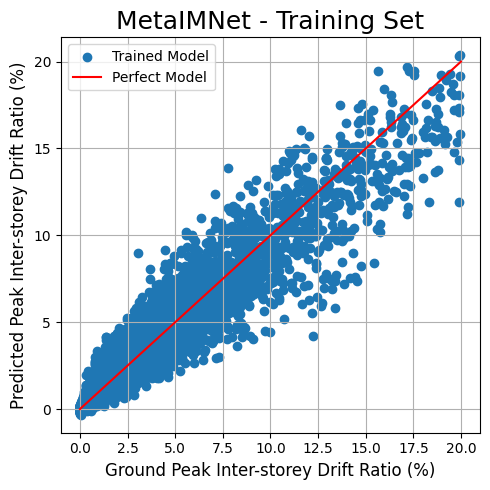

RMSE = 1.011, R2 = 0.902


In [12]:
plot_scatter_results(train_data, 'MetaIMNet - Training Set')

## Loss Evolution

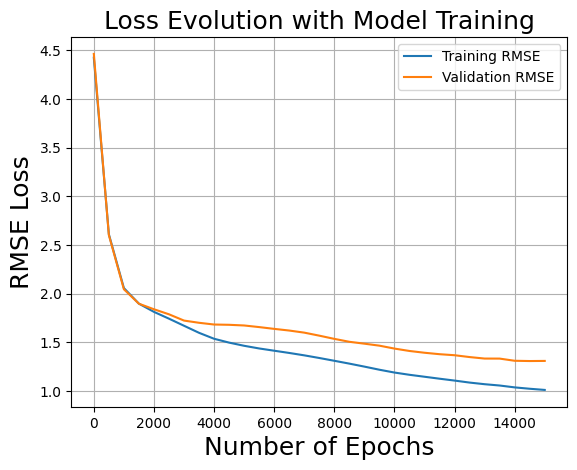

In [13]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training RMSE')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation RMSE')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("RMSE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [14]:
y_pred_test = predict_tradnet(model, x_test)
test_data['drift_ratio_pred'] = y_pred_test.detach().view(-1).numpy()

## True v/s Predicted Response on Test Data

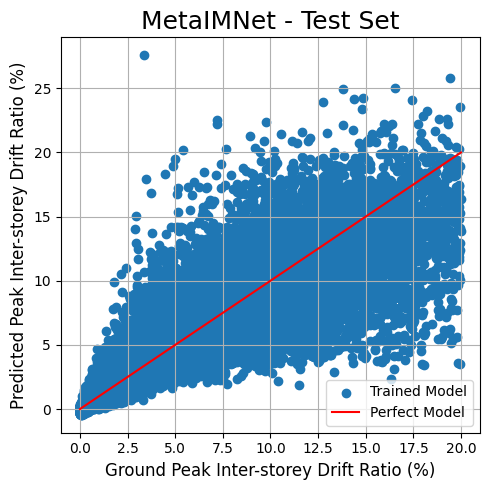

RMSE = 1.428, R2 = 0.802


In [15]:
plot_scatter_results(test_data, 'MetaIMNet - Test Set')

## True v/s Predicted Response on Combined Train, Validation, and Test Data

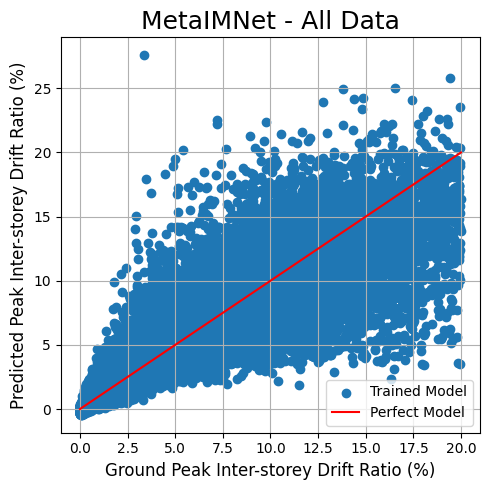

RMSE = 1.389, R2 = 0.813


In [16]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_scatter_results(all_data, 'MetaIMNet - All Data')

In [18]:
# all_data.to_parquet('all_data_drift_trad_reg.parquet', engine = 'pyarrow')